In [1]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


In [2]:
def analyze_image_sizes(folder_path):
    image_sizes = set()  # Используем множество для уникальных размеров

    # Перебираем папки apples и tomatoes внутри train и test
    for subdir in ['apples', 'tomatoes']:
        subdir_path = os.path.join(folder_path, subdir)
        if not os.path.exists(subdir_path):
            print(f"Folder '{subdir}' not found in '{folder_path}'")
            continue

        # Перебираем изображения в каждой папке apples и tomatoes
        for filename in os.listdir(subdir_path):
            if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(subdir_path, filename)
                with Image.open(image_path) as img:
                    image_sizes.add(img.size)

    return image_sizes

train_folder = "apples_and_tomatoes/train"
test_folder = "apples_and_tomatoes/test"

train_image_sizes = analyze_image_sizes(train_folder)
test_image_sizes = analyze_image_sizes(test_folder)

print("Train image sizes:", train_image_sizes)
print("Test image sizes:", test_image_sizes)

Train image sizes: {(224, 224)}
Test image sizes: {(224, 224)}


In [3]:
def resize_images(folder_path, target_size=(224, 224)):
    for subdir in ['apples', 'tomatoes']:
        subdir_path = os.path.join(folder_path, subdir)
        if not os.path.exists(subdir_path):
            print(f"Папка '{subdir}' не найдена в '{folder_path}'")
            continue

        for filename in os.listdir(subdir_path):
            if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(subdir_path, filename)
                try:
                    with Image.open(image_path) as img:
                        # Проверяем, находится ли изображение в режиме палитры
                        if img.mode == 'P':
                            img = img.convert('RGB')  # Преобразовываем в режим RGB
                        resized_img = img.resize(target_size)
                        resized_img.save(image_path)  # Перезаписываем изображение измененным
                except (OSError, ValueError, AttributeError, UnidentifiedImageError) as e:
                    print(f"Ошибка обработки изображения '{image_path}': {e}")
                    continue

In [4]:
# Функция для загрузки изображений и их меток
def load_images(folder_path):
    images = []
    labels = []

    for label, category in enumerate(['apples', 'tomatoes']):
        category_path = os.path.join(folder_path, category)
        for filename in os.listdir(category_path):
            if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                image_path = os.path.join(category_path, filename)
                img = Image.open(image_path)
                images.append(np.array(img))
                labels.append(label)

    return np.array(images), np.array(labels)

In [5]:
# Изменяем размер изображений
resize_images(train_folder)
resize_images(test_folder)

# Загружаем обучающие и тестовые изображения и метки
train_images, train_labels = load_images(train_folder)
test_images, test_labels = load_images(test_folder)

# Разделяем данные на обучающий и валидационный наборы
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

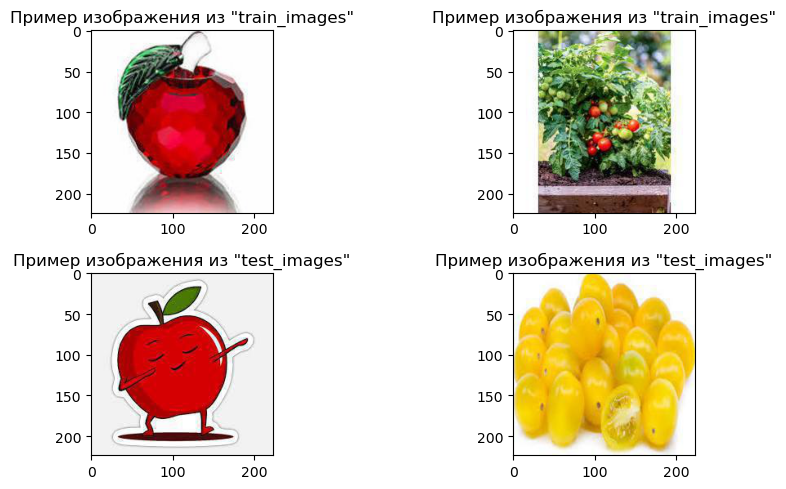

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(train_images[5])
plt.title('Пример изображения из "train_images"')

plt.subplot(2, 2, 2)
plt.imshow(train_images[-5])
plt.title('Пример изображения из "train_images"')

plt.subplot(2, 2, 3) 
plt.imshow(test_images[2])
plt.title('Пример изображения из "test_images"')

plt.subplot(2, 2, 4) 
plt.imshow(test_images[-2])
plt.title('Пример изображения из "test_images"')

plt.tight_layout()
plt.show()

In [7]:
# Применение взвешивания классов
class_weights = {0: 1.0, 1: 160/130}  # Веса классов для компенсации неравномерности

In [14]:
train_folder = "apples_and_tomatoes/train"  # Путь к обучающим данным
test_folder = "apples_and_tomatoes/test"  # Путь к тестовым данным

# Создание генераторов для данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

print('Обучающая выборка: ')
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

print('Тестовая выборка: ')
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Обучающая выборка: 
Found 290 images belonging to 2 classes.
Тестовая выборка: 
Found 97 images belonging to 2 classes.


In [9]:
# Создаем генераторы данных для аугментации изображений
#train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
#)
#val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Использование ResNet50 и Transfer Learning

base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [11]:
# Создаем модель ResNet50
#resnet_model = Sequential([
#    ResNet50(include_top=False, pooling='avg', weights='imagenet'),
#    Dense(2, activation='softmax')
#])

# Замораживаем веса предварительно обученной части модели
#resnet_model.layers[0].trainable = False

# Компилируем модель
#resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Компиляция модели с весами классов и обучение
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=50, validation_data=test_generator, class_weight=class_weights)

# Оценка и вывод итоговой точности модели на тестовых данных
metrics = model.evaluate(test_generator)
print(f'Итоговая точность модели на тестовых данных: {metrics[1]}')

Epoch 1/50
10/10 [==============================] - 38s 1s/step - loss: 0.9771 - accuracy: 0.5000 - val_loss: 0.6864 - val_accuracy: 0.5773
Epoch 2/50
10/10 [==============================] - 9s 936ms/step - loss: 0.8603 - accuracy: 0.5000 - val_loss: 0.6744 - val_accuracy: 0.5464
Epoch 3/50
10/10 [==============================] - 9s 1s/step - loss: 0.8892 - accuracy: 0.5448 - val_loss: 0.8246 - val_accuracy: 0.4433
Epoch 4/50
10/10 [==============================] - 9s 836ms/step - loss: 0.8503 - accuracy: 0.5034 - val_loss: 0.6686 - val_accuracy: 0.5567
Epoch 5/50
10/10 [==============================] - 10s 968ms/step - loss: 0.7540 - accuracy: 0.5931 - val_loss: 0.6832 - val_accuracy: 0.4948
Epoch 6/50
10/10 [==============================] - 9s 911ms/step - loss: 0.7970 - accuracy: 0.5379 - val_loss: 0.6679 - val_accuracy: 0.5567
Epoch 7/50
10/10 [==============================] - 9s 900ms/step - loss: 0.7958 - accuracy: 0.5379 - val_loss: 0.6859 - val_accuracy: 0.4845
Epoch 8/50

In [13]:
# Обучаем модель
#history = resnet_model.fit(
#    train_datagen.flow(train_images, train_labels, batch_size=32),
#    steps_per_epoch=len(train_images) // 32,
#    epochs=30,
#    validation_data=val_datagen.flow(val_images, val_labels),
#    validation_steps=len(val_images) // 32
#)

# Оцениваем модель на тестовом наборе
#test_loss, test_accuracy = resnet_model.evaluate(test_images / 255.0, test_labels, verbose=2)
#print("Test accuracy:", test_accuracy)